In [42]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 10,6

In [4]:
%store -r prod_reduced

In [5]:
prod_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 0 to 36135
Data columns (total 12 columns):
calendar_day                      14820 non-null datetime64[ns]
production_process                14820 non-null category
production_process_description    14820 non-null category
strategy                          14820 non-null category
work_center                       13450 non-null category
wc_description                    14820 non-null category
block                             14815 non-null object
shape                             14795 non-null category
size                              14795 non-null object
sku                               14820 non-null object
material_description              14820 non-null object
ton                               14820 non-null int64
dtypes: category(6), datetime64[ns](1), int64(1), object(4)
memory usage: 897.4+ KB


In [25]:
justton=prod_reduced[['calendar_day','ton']]
justton=justton[justton['ton'] > 1]
print(justton.count())
inddf=justton.set_index('calendar_day')

calendar_day    12485
ton             12485
dtype: int64


In [26]:
grouper=inddf.resample('M').sum()

In [33]:
print(grouper.count())
print(grouper.tail())


ton    83
dtype: int64
                ton
calendar_day       
2019-08-31     8221
2019-09-30    37758
2019-10-31    45647
2019-11-30    42609
2019-12-31    17141


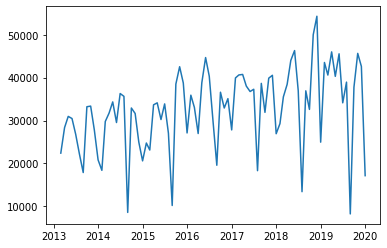

In [31]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.plot(grouper)

In [39]:
#to check if the data is stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    #dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

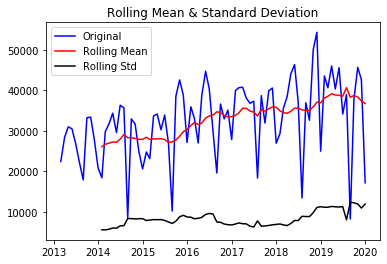

Results of Dickey-Fuller Test:
Test Statistic                 -1.595557
p-value                         0.485825
#Lags Used                     11.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [40]:
test_stationarity(grouper)

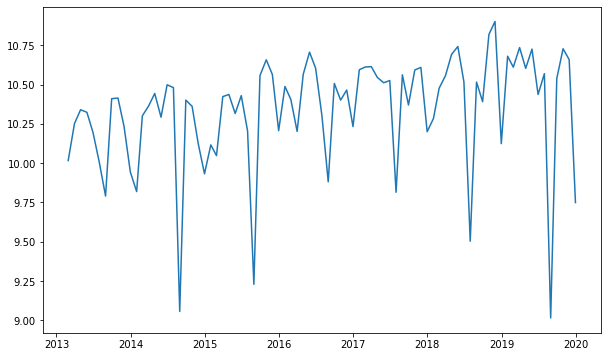

In [44]:
df_log = np.log(grouper)
plt.plot(df_log)

# differencing

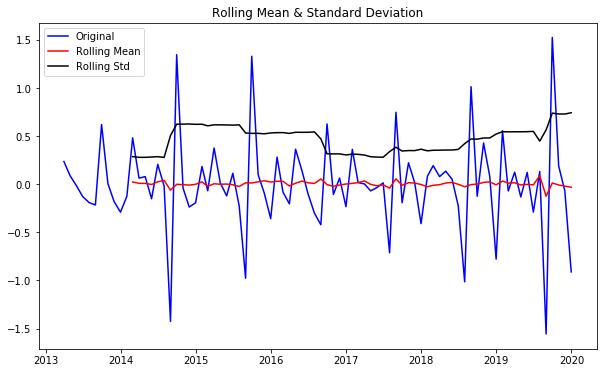

Results of Dickey-Fuller Test:
Test Statistic                 -5.582206
p-value                         0.000001
#Lags Used                     11.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [45]:
ts_diff = df_log - df_log.shift()
ts_diff.dropna(inplace = True)

test_stationarity(ts_diff)

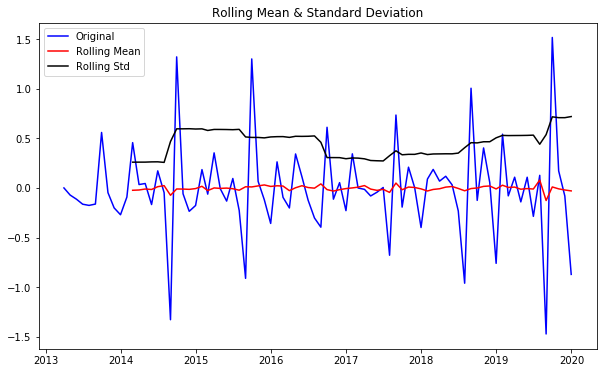

Results of Dickey-Fuller Test:
Test Statistic                -5.845583e+00
p-value                        3.690322e-07
#Lags Used                     1.100000e+01
Number of Observations Used    7.000000e+01
Critical Value (1%)           -3.527426e+00
Critical Value (5%)           -2.903811e+00
Critical Value (10%)          -2.589320e+00
dtype: float64


In [46]:
ts_diff_exp = ts_diff  - ts_diff.ewm(halflife = 12).mean()
ts_diff_exp.dropna(inplace = True)
test_stationarity(ts_diff_exp)

Decomposing

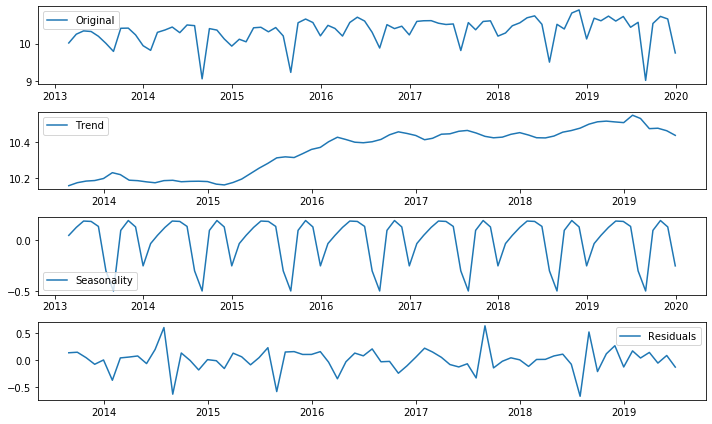

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [47]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [48]:
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial Autocorrelation Function')

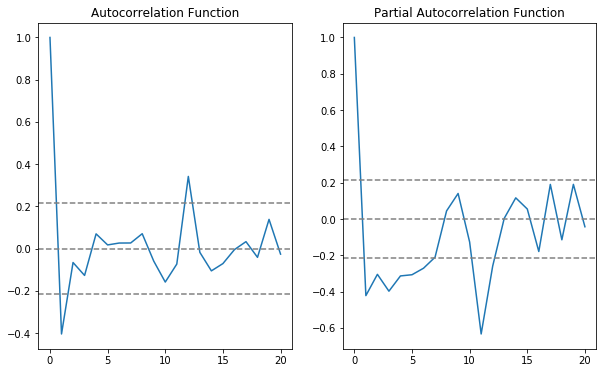

In [49]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

In [53]:
from statsmodels.tsa.arima_model import ARIMA

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  """


TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

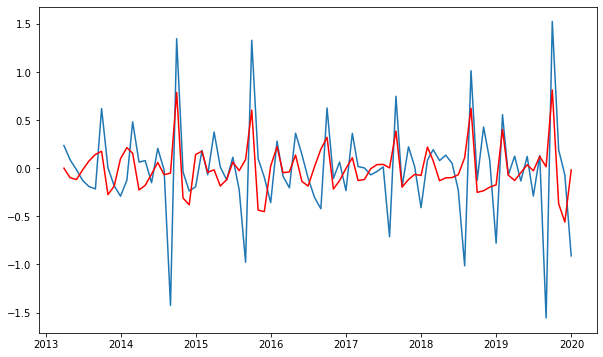

In [55]:
model = ARIMA(df_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))